### Aquiring and importing night-lights data 

Imagery displaying observed light at night over the country of Burundi was downloaded from the NOAA VIIRS website: https://ngdc.noaa.gov/eog/viirs/download_ut_mos.html Burundi is contained within Tile 5, just slightly below the equator. 

We will use satellite day and night time from 2017. Burundi's dry season spans June to late September. Imagery will be collected as close to August 15th, 2017 to minimize noise created from seasonality between the datasets and increase the likelhood the images will be cloud free. 


#### Preprocessing: 

Images downloaded from the above website are free of inherent geographic information. To convert the image from png to tiff while applying the coordinate system, I the following gdal command via the cli: 

```
gdal_translate  -a_srs EPSG:4326  -co compress=LZW SVDNB_npp_d20170815.d.00N060W.png Burundi_20170815.tiff
```

In [2]:
import os
import warnings
from pprint import pprint
import descarteslabs as dl

In [3]:
# *************FIND COUNTRY BOUNDARY ***************
matches = dl.places.find('burundi')
aoi = matches[0]
pprint(aoi)
shape = dl.places.shape(aoi['slug'], geom='low')

{'bbox': [29.001302, -4.468538, 30.849959, -2.309987],
 'id': 85632285,
 'name': 'Burundi',
 'path': 'continent:africa_country:burundi',
 'placetype': 'country',
 'slug': 'africa_burundi'}


In [32]:
# *************OPEN AN EXISTING IMAGE FROM DISK ***************
from osgeo import gdal
import numpy as np
raster_data_path = "data/black-marble/night_lights_clipped.tif"
raster_dataset = gdal.Open(raster_data_path, gdal.GA_ReadOnly)


In [16]:
geo_transform = raster_dataset.GetGeoTransform()
#     (416415.0, 30.0, 0.0, 6663145.0, 0.0, -30.0)
proj = raster_dataset.GetProjectionRef()
#     PROJCS["WGS 84 / UTM zone 20S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-63],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","32720"]]
bands_data = []
for b in range(1, raster_dataset.RasterCount+1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())
#     [array dtype=float32],[...], ...
bands_data = np.dstack(bands_data)

# Validate data
rows, cols, n_bands = bands_data.shape
# print (rows, cols, n_bands)

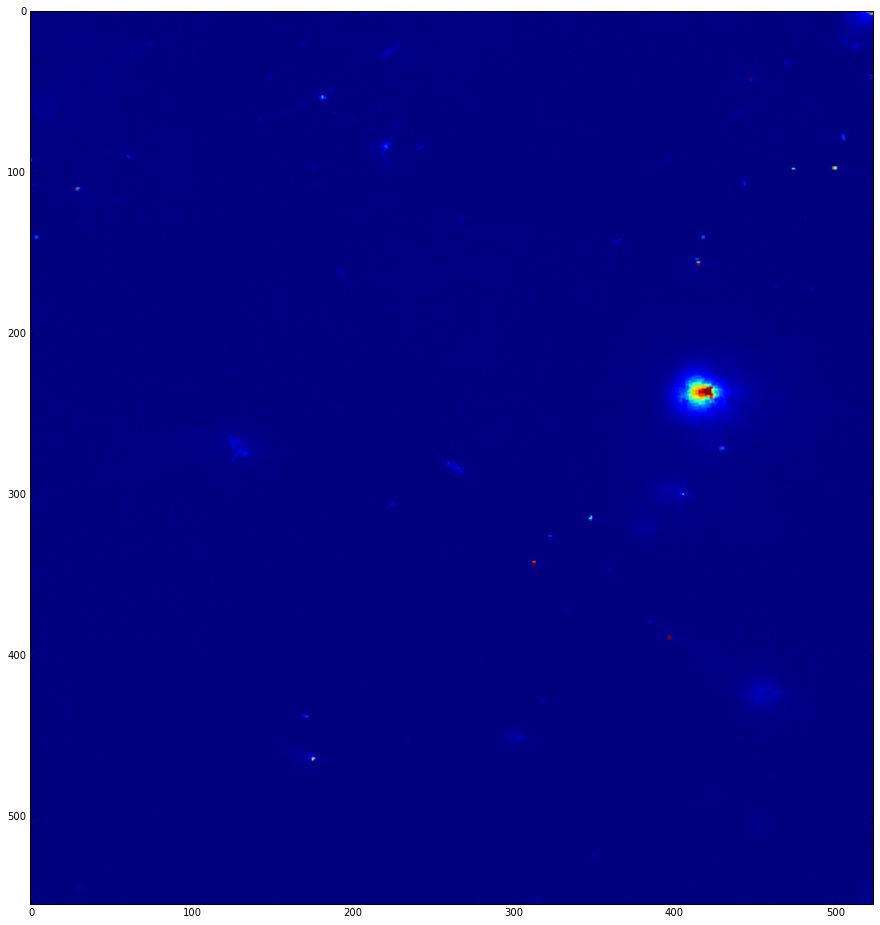

In [12]:
# *************PLOT SINGLE IMAGE ***************

import matplotlib.pyplot as plt
%matplotlib inline


plot_data = bands_data.squeeze()
plot_data.shape


plt.figure(figsize=[16,16])
plt.imshow(plot_data)

### Classification

We need a library of functions to rasterize our training and test data for analysis:

In [13]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    print(vector_data_path)
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    print(data_source)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize the vectors in the given directory in a single image."""
    labeled_pixels = np.zeros((rows, cols))
    print
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels


def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file

Define training data:

In [14]:
output_fname = "data/black-marble/classification.tiff"
train_data_path = "data/black-marble/train/"
validation_data_path = "data/black-marble/test/"

Let's process the input training dataset.  Project all the vector data, in the training dataset, into a numpy array. Each class is assigned a label (a number between 1 and the total number of classes). If the value v in the position (i, j) of this new array is not zero, that means that the pixel (i, j) must be used as a training sample of class v.

```training_samples``` is the list of pixels to be used for training. In our case, a pixel is a point in the nth-dimensional space of the bands.

```training_labels``` is a list of class labels such that the i-th position indicates the class for i-th pixel in ```training_samples```

In [17]:
files = [f for f in os.listdir(train_data_path) if f.endswith('.shp')]
classes = [f.split('.')[0] for f in files]
print(classes)
shapefiles = [os.path.join(train_data_path, f)
              for f in files if f.endswith('.shp')]

labeled_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform,
                                   proj)
print(shapefiles, rows, cols, geo_transform, proj)
is_train = np.nonzero(labeled_pixels)
training_labels = labeled_pixels[is_train]
training_samples = bands_data[is_train]

['dark_train', 'light_train']
data/black-marble/train/dark_train.shp
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x116f06f60> >
data/black-marble/train/light_train.shp
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x116f06990> >
['data/black-marble/train/dark_train.shp', 'data/black-marble/train/light_train.shp'] 555 524 (28.822917377250008, 0.0041666667, 0.0, -2.24375001795, 0.0, -0.0041666667) GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]


Now that we have all our parameters, we can instantiate a RandomForestClassifier from Scikit-learn to train a model for the classification. 

I have used the bare minimum to get the classification going, but will fine tune the parameters.

In [20]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(training_samples, training_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

To see the training data plotted:

In [ ]:
print(training_labels.shape)
print(training_samples.shape)
# Make the plot
plt.scatter(training_labels, training_samples, color='r', marker='o')

# Add some axis labels
plt.xlabel('Training Lables')
plt.ylabel('Training Samples')

# Add a title
plt.title('Training Data')

Let's apply the model to the night lights image for classification. 


In [22]:
n_samples = rows*cols
flat_pixels = bands_data.reshape((n_samples, n_bands))
result = classifier.predict(flat_pixels)
classification = result.reshape((rows, cols))

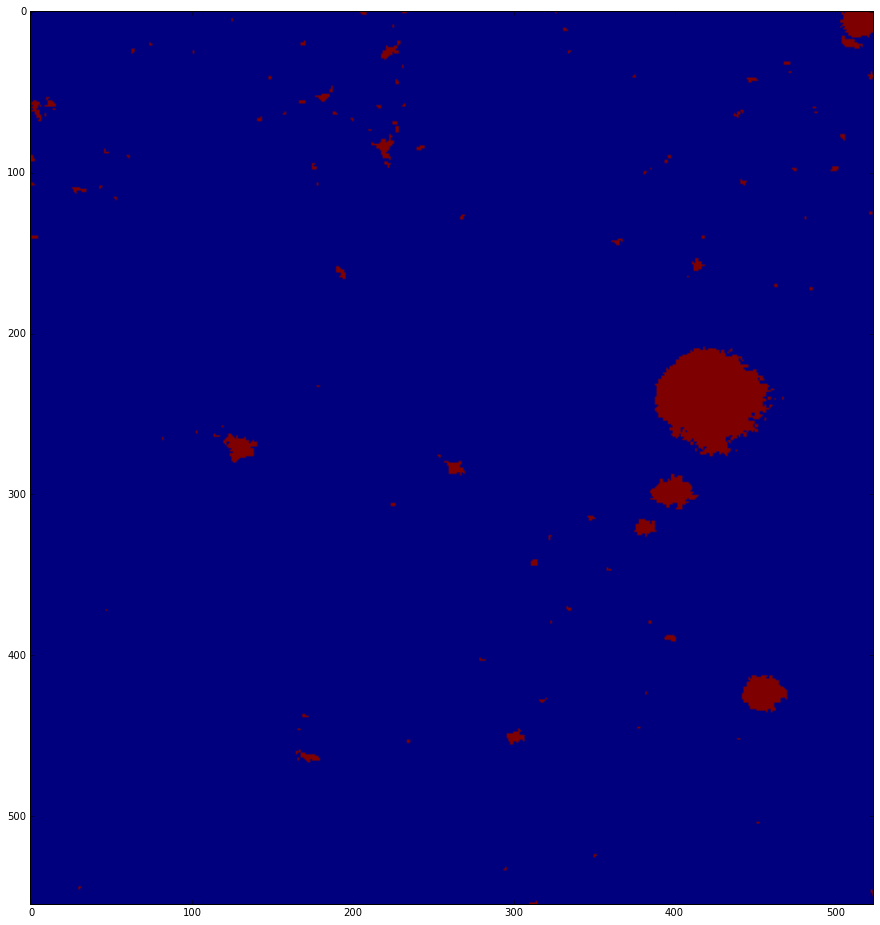

In [23]:
from matplotlib import pyplot as plt

plt.figure(figsize=[16,16])
plt.imshow(classification)


### Accuracy assessment 

I will use a confusion matrix and p-scores to assess the accuracy of the classified image. We need to output our classified image and preproess our test datasets before performing out accuracy assessment.

In [24]:
write_geotiff(output_fname, classification, geo_transform, proj)

Preprocess the test vector datasets:

In [26]:

# shapefiles = [os.path.join(validation_data_path, "%s.shp" % c)
#               for c in classes]

shapefiles = ['data/black-marble/test/dark_test.shp', 'data/black-marble/test/light_test.shp']
print(['data/black-marble/test/dark_test.shp', 'data/black-marble/test/light_test.shp'])

print(rows)
print(cols)
print(geo_transform)
                              

verification_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform,
                                   proj)

for_verification = np.nonzero(verification_pixels)
verification_labels = verification_pixels[for_verification]
predicted_labels = classification[for_verification]

['data/black-marble/test/dark_test.shp', 'data/black-marble/test/light_test.shp']
555
524
(28.822917377250008, 0.0041666667, 0.0, -2.24375001795, 0.0, -0.0041666667)
data/black-marble/test/dark_test.shp
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x1a1bb6a150> >
data/black-marble/test/light_test.shp
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x1a1bb6a270> >


In [27]:
print("Confussion matrix:\n%s" %
      metrics.confusion_matrix(verification_labels, predicted_labels))

Confussion matrix:
[[13  0]
 [ 0 10]]


In [28]:
target_names = ['Class %s' % s for s in classes]
print("Classification report:\n%s" %
      metrics.classification_report(verification_labels, predicted_labels,
                                    target_names=target_names))
print("Classification accuracy: %f" %
      metrics.accuracy_score(verification_labels, predicted_labels))

Classification report:
                   precision    recall  f1-score   support

 Class dark_train       1.00      1.00      1.00        13
Class light_train       1.00      1.00      1.00        10

      avg / total       1.00      1.00      1.00        23

Classification accuracy: 1.000000
